# Load Libraris and Data

In [27]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re

In [28]:
twitter_data = pd.read_csv(r"../data/scored_tweets_total.csv")

# Creating Digraph

To show the number of time someone is being mentioned

In [42]:
import networkx as nx
import re

def extract_mentions(text):
    if isinstance(text, str):
        return re.findall(r'@(\w+)', text)
    return []

G = nx.DiGraph()

# Add all users as nodes
for screen_name in twitter_data['user.screen_name'].unique():
    G.add_node(screen_name)

# Add edges based on mentions
for index, row in twitter_data.iterrows():
    sender = row['user.screen_name']
    mentions = extract_mentions(row['text'])
    for mentioned in mentions:
        # Mentioned handle not in the dataset
        if mentioned not in np.unique(twitter_data["user.screen_name"]):
            continue
        if G.has_edge(sender, mentioned):
            G[sender][mentioned]['weight'] += 1
        else:
            G.add_edge(sender, mentioned, weight=1)

# Add node attributes (pumper status)
for index, row in twitter_data.iterrows():
    G.nodes[row['user.screen_name']]['pumper'] = row['Known_Pumper']

# Print the graph
print(G.edges(data=True))
print(G.nodes(data=True))

[('UCitnow', 'UCitnow', {'weight': 3}), ('UCitnow', 'ShortSqueezed1', {'weight': 2}), ('christinebarnum', 'GetScanz', {'weight': 1}), ('christinebarnum', 'BrandonKodallas', {'weight': 1}), ('CharlesMorriz', 'GetScanz', {'weight': 1}), ('CharlesMorriz', 'JoeDTrader', {'weight': 1}), ('CharlesMorriz', 'Candy_OTC', {'weight': 1}), ('CharlesMorriz', 'AlexDelarge6553', {'weight': 1}), ('jehause', 'Kelvin_OTC', {'weight': 1}), ('jehause', 'allfacnocap', {'weight': 1}), ('HiegerBrian', 'jehause', {'weight': 1}), ('soupbone1965', 'jehause', {'weight': 1}), ('soupbone1965', 'Glenn12399', {'weight': 1}), ('soupbone1965', 'TTrader1976', {'weight': 1}), ('soupbone1965', 'EEENF_ARMY', {'weight': 2}), ('LeifBierer', 'jehause', {'weight': 3}), ('LeifBierer', 'GeniusTrader777', {'weight': 1}), ('LeifBierer', 'splendira', {'weight': 1}), ('LeifBierer', 'Ninja1Stock', {'weight': 1}), ('DaveWhitman12', 'jehause', {'weight': 1}), ('DaveWhitman12', 'PremiumCashFlow', {'weight': 3}), ('DaveWhitman12', 'dayo

# Get Network Metrics and pumper connectivity

In [43]:
# Calculate network features
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
pagerank = nx.pagerank(G)

# Add centrality measures as node attributes
for node in G.nodes():
    G.nodes[node]['degree_centrality'] = degree_centrality[node]
    G.nodes[node]['betweenness_centrality'] = betweenness_centrality[node]
    G.nodes[node]['eigenvector_centrality'] = eigenvector_centrality[node]
    G.nodes[node]['pagerank'] = pagerank[node]

# Calculate mention counts
mention_counts = {}
for node in G.nodes():
    mention_counts[node] = {
        'mentions_sent': len([edge for edge in G.out_edges(node)]),
        'mentions_received': len([edge for edge in G.in_edges(node)])
    }

# Add mention counts as node attributes
for node in G.nodes():
    G.nodes[node]['mentions_sent'] = mention_counts[node]['mentions_sent']
    G.nodes[node]['mentions_received'] = mention_counts[node]['mentions_received']

# Calculate pumper connection ratio
for node in G.nodes():
    pumper_count = 0
    neighbor_count = 0
    for neighbor in G.neighbors(node):
        neighbor_count += 1
        if 'pumper' in G.nodes[neighbor]:
            if G.nodes[neighbor]['pumper'] == 1:
                pumper_count += 1
        else:
            print(f"Warning: Node '{neighbor}' has no 'pumper' attribute.")
    if G.nodes[node]['pumper']:
        G.nodes[node]['pumper_ratio'] = 1
    elif neighbor_count > 0:
        G.nodes[node]['pumper_ratio'] = pumper_count / neighbor_count
    else:
        G.nodes[node]['pumper_ratio'] = 0

In [44]:
# Create feature matrix
node_features = []
node_labels = []
node_names = []
for node in G.nodes():
    node_features.append([
        G.nodes[node]['degree_centrality'],
        G.nodes[node]['betweenness_centrality'],
        G.nodes[node]['eigenvector_centrality'],
        G.nodes[node]['pagerank'],
        G.nodes[node]['mentions_sent'],
        G.nodes[node]['mentions_received'],
        G.nodes[node]['pumper_ratio']
    ])
    node_labels.append(G.nodes[node]['pumper'])
    node_names.append(node)

feature_df = pd.DataFrame(node_features, columns=[
    'degree_centrality',
    'betweenness_centrality',
    'eigenvector_centrality',
    'pagerank',
    'mentions_sent',
    'mentions_received',
    'pumper_ratio'
])
target_series = pd.Series(node_labels)
name_series = pd.Series(node_names)

In [61]:
density = nx.density(G)
print(f"Graph density: {density}")

Graph density: 0.00033683468711034317


Damn Sparse

In [50]:
print(feature_df)

      degree_centrality  betweenness_centrality  eigenvector_centrality  \
0              0.000826                0.000000            1.224147e-12   
1              0.000000                0.000000            1.167437e-18   
2              0.001927                0.000000            2.695172e-03   
3              0.002202                0.000243            1.455844e-02   
4              0.001101                0.000000            1.167437e-18   
...                 ...                     ...                     ...   
3629           0.000275                0.000000            1.167437e-18   
3630           0.000275                0.000000            1.167437e-18   
3631           0.000275                0.000000            1.167437e-18   
3632           0.000000                0.000000            1.167437e-18   
3633           0.000275                0.000000            1.167437e-18   

      pagerank  mentions_sent  mentions_received  pumper_ratio  
0     0.000208              2     

# Model Training to get User Probability

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Modified User Probability Calculation
node_features = []
node_labels = []
node_names = []
for node in G.nodes():
    node_features.append([
        G.nodes[node]['degree_centrality'],
        G.nodes[node]['pumper_ratio'] #only use these two features, because of sparsity.
    ])
    if 'pumper' in G.nodes[node]:
        node_labels.append(G.nodes[node]['pumper'])
    else:
        node_labels.append(np.nan)
    node_names.append(node)

feature_df = pd.DataFrame(node_features, columns=[
    'degree_centrality',
    'pumper_ratio',
])
target_series = pd.Series(node_labels)
name_series = pd.Series(node_names)

not_nan_index = target_series.notna()
feature_df = feature_df[not_nan_index]
target_series = target_series[not_nan_index]
name_series = name_series[not_nan_index]

X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    feature_df, target_series, name_series, test_size=0.2, random_state=42
)

model = LogisticRegression()
model.fit(X_train, y_train)

probabilities = model.predict_proba(X_test)[:, 1]

user_pumper_probabilities = {}
for i, user in enumerate(names_test):
    if user in G.nodes() and 'pumper' in G.nodes[user] and G.nodes[user]['pumper'] == 1:
        user_pumper_probabilities[user] = max(0.8, probabilities[i])  # Strong prior
    else:
        user_pumper_probabilities[user] = probabilities[i]

(array([719.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   8.]),
 array([0.00512319, 0.08461087, 0.16409855, 0.24358623, 0.32307391,
        0.40256159, 0.48204927, 0.56153696, 0.64102464, 0.72051232,
        0.8       ]),
 <BarContainer object of 10 artists>)

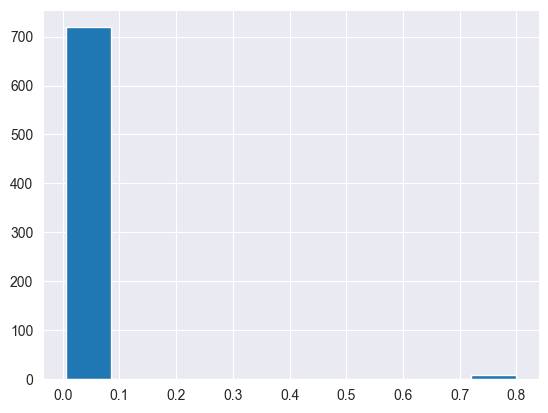

In [60]:
import matplotlib.pyplot as plt

plt.hist(user_pumper_probabilities.values())

In [58]:
density = nx.density(G)
print(f"Graph density: {density}")

Graph density: 0.00033683468711034317


# Using Tweet to train model

In [62]:
twitter_data['user_pumper_probability'] = twitter_data['user.screen_name'].map(user_pumper_probabilities)
twitter_data['user_pumper_probability'] = twitter_data['user_pumper_probability'].fillna(0.5)

In [ ]:
import pandas as pd
import re
import emoji
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2  # Add feature selection

def count_hashtags(text):
    if isinstance(text, str):
        return len(re.findall(r'#\w+', text))
    return 0

def count_emojis(text):
    if isinstance(text, str):
        return len([char for char in text if char in emoji.EMOJI_DATA])
    return 0

def preprocess_text(text):
    if isinstance(text, str):
        text = emoji.demojize(text)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'[^\w\s#]', '', text)
        text = re.sub(r'[^a-zA-Z\s#]', '', text)
        text = text.lower()
        return text
    else:
        return ""

def align_tfidf_columns(train_tfidf_df, test_tfidf_df):
    """Aligns TF-IDF columns between training and test DataFrames."""
    train_cols = set(train_tfidf_df.columns)
    test_cols = set(test_tfidf_df.columns)

    common_cols = list(train_cols & test_cols)
    missing_train_cols = list(test_cols - train_cols)
    missing_test_cols = list(train_cols - test_cols)

    for col in missing_train_cols:
        train_tfidf_df[col] = 0

    for col in missing_test_cols:
        test_tfidf_df[col] = 0

    return train_tfidf_df[common_cols + missing_test_cols], test_tfidf_df[common_cols + missing_train_cols]

def create_ml_pipeline_with_tfidf_oversampling(df, classifier, text_column='text', target_column='user_pumper_probability', numerical_columns=["emoji_count", "hashtag_count"], oversampling=True, max_tfidf_features=1500, param_grid=None): #reduced max_tfidf_features
    """
    Creates a machine learning pipeline with TF-IDF, emoji/hashtag counts, and optional SMOTE oversampling.
    Returns metrics for both train and test sets.
    """

    df['hashtag_count'] = df[text_column].apply(count_hashtags)
    df['emoji_count'] = df[text_column].apply(count_emojis)
    df[text_column] = df[text_column].apply(preprocess_text)

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    vectorizer = TfidfVectorizer(max_features=max_tfidf_features, stop_words='english', ngram_range=(1, 2)) #added ngram
    train_tfidf_matrix = vectorizer.fit_transform(X_train[text_column])
    test_tfidf_matrix = vectorizer.transform(X_test[text_column])

    train_tfidf_df = pd.DataFrame(train_tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    test_tfidf_df = pd.DataFrame(test_tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    train_tfidf_df, test_tfidf_df = align_tfidf_columns(train_tfidf_df, test_tfidf_df)

    X_train = X_train.reset_index(drop=True)
    train_tfidf_df = train_tfidf_df.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    test_tfidf_df = test_tfidf_df.reset_index(drop=True)
    
    X_train = pd.concat([X_train.drop(text_column, axis=1), train_tfidf_df], axis=1)
    X_test = pd.concat([X_test.drop(text_column, axis=1), test_tfidf_df], axis=1)

    if oversampling:
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train, y_train

    tfidf_columns = [col for col in X_train.columns if col not in numerical_columns and col != 'hashtag_count' and col != 'emoji_count']

    # Feature selection
    feature_selector = SelectKBest(chi2, k=min(200, len(tfidf_columns))) #added feature selection
    X_train_selected = feature_selector.fit_transform(X_train_resampled[tfidf_columns], y_train_resampled)
    X_test_selected = feature_selector.transform(X_test[tfidf_columns])

    selected_tfidf_columns = [tfidf_columns[i] for i in feature_selector.get_support(indices=True)]
    X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_tfidf_columns)
    X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_tfidf_columns)

    X_train_final = pd.concat([X_train_resampled[numerical_columns].reset_index(drop=True), X_train_selected_df.reset_index(drop=True)], axis=1)
    X_test_final = pd.concat([X_test[numerical_columns].reset_index(drop=True), X_test_selected_df.reset_index(drop=True)], axis=1)

    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', MinMaxScaler(), numerical_columns + ['hashtag_count', 'emoji_count']),
            ('tfidf', 'passthrough', selected_tfidf_columns) #use selected columns
        ],
        remainder='drop'
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    if param_grid is not None:
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=3)
        grid_search.fit(X_train_final, y_train_resampled)
        pipeline = grid_search.best_estimator_

    else:
        pipeline.fit(X_train_final, y_train_resampled)

    y_train_pred = pipeline.predict(X_train_final)
    y_test_pred = pipeline.predict(X_test_final)

    train_metrics = {
        'accuracy': accuracy_score(y_train_resampled, y_train_pred),
        'precision': precision_score(y_train_resampled, y_train_pred),
        'recall': recall_score(y_train_resampled, y_train_pred),
        'f1': f1_score(y_train_resampled, y_train_pred),
        'roc_auc': roc_auc_score(y_train_resampled, pipeline.predict_proba(X_train_final)[:, 1]),
        'confusion_matrix': confusion_matrix(y_train_resampled, y_train_pred)
    }

    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, pipeline.predict_proba(X_test_final)[:, 1]),
        'confusion_matrix': confusion_matrix(y_test, y_test_pred)
    }
    
    return pipeline, vectorizer, train_metrics, test_metrics